In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
# Read dataset file
df = pd.read_csv('Yamaha.csv', delimiter=";")
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [3]:
print(df.dtypes)

Date      object
Price     object
Open      object
High      object
Low       object
Volume    object
Change    object
dtype: object


In [4]:
df['Price'] = df['Price'].str.replace(',', '.').astype(float)
df['Open'] = df['Open'].str.replace(',', '.').astype(float)
df['High'] = df['High'].str.replace(',', '.').astype(float)
df['Low'] = df['Low'].str.replace(',', '.').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '.').astype(float)
df['Change'] = df['Change'].str.replace(',', '.').astype(float)

print(df)
df.describe()

            Date   Price    Open    High     Low     Volume  Change
0     04/01/2018  4320.0  4210.0  4320.0  4205.0  1160000.0  0.0385
1     05/01/2018  4380.0  4340.0  4385.0  4315.0   942600.0  0.0139
2     09/01/2018  4465.0  4415.0  4470.0  4375.0   968700.0  0.0194
3     10/01/2018  4520.0  4470.0  4530.0  4465.0   764000.0  0.0123
4     11/01/2018  4540.0  4525.0  4545.0  4515.0   796800.0  0.0044
...          ...     ...     ...     ...     ...        ...     ...
1447  08/12/2023  3216.0  3271.0  3271.0  3199.0  1440000.0 -0.0168
1448  11/12/2023  3216.0  3259.0  3269.0  3213.0   944400.0  0.0000
1449  12/12/2023  3176.0  3269.0  3271.0  3174.0   991400.0 -0.0124
1450  13/12/2023  3218.0  3190.0  3230.0  3190.0  1040000.0  0.0132
1451  14/12/2023  3142.0  3205.0  3205.0  3133.0  1110000.0 -0.0236

[1452 rows x 7 columns]


,Price,Open,High,Low,Volume,Change
count,1452.000000,1452.000000,1452.000000,1452.000000,1.452000e+03,1452.000000
mean,5342.451102,5344.658402,5400.580579,5283.276171,6.088632e+05,0.000012
std,695.721143,694.041663,698.877570,688.962765,3.185040e+05,0.020299
min,3142.000000,3190.000000,3205.000000,3133.000000,1.144000e+05,-0.145700
25%,4938.750000,4940.000000,4990.000000,4890.000000,4.071750e+05,-0.011325
50%,5315.000000,5320.000000,5370.000000,5260.000000,5.324000e+05,0.000000
75%,5770.000000,5790.000000,5840.000000,5720.000000,7.116750e+05,0.010700
max,7440.000000,7450.000000,7490.000000,7360.000000,3.140000e+06,0.126700


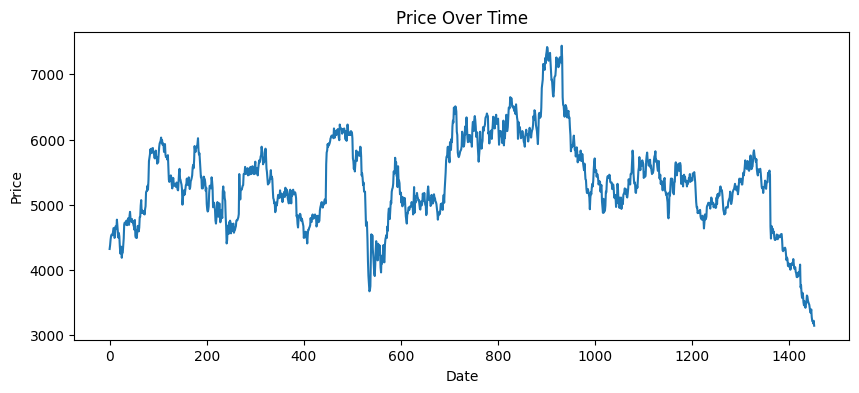

In [5]:
# Assuming you have a DataFrame 'df' with a 'Price' column
plt.figure(figsize=(10, 4))
plt.plot(df['Price'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [6]:
# Split the data into training & testing sets by 7:3
train_size = int(0.8 * len(df['Price']))
test_size = len(df['Price']) - train_size

train_data = df[:train_size]
test_data = df[train_size:train_size + test_size]

In [7]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14206.970, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14208.716, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14210.363, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14210.359, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14206.770, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14212.303, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.998 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
# make predictions on the testing set
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [9]:
# 6. Create index next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

In [10]:
# Calculate RMSE for the testing set
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

# Calculate MAPE for the testing set
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Testing MAPE:", test_mape)

# Calculate MAE for the testing set
test_mae = np.mean(np.abs(y_pred - y_test))
print("Testing MAE:", test_mae)

def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * (error ** 2)
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    loss = np.where(is_small_error, squared_loss, linear_loss)
    return np.mean(loss)

# Calculate Huber Loss for the testing set
test_huber_loss = huber_loss(y_test, y_pred, delta=1.0)
print("Testing Huber Loss:", test_huber_loss)

Testing RMSE: 739.748364385947
Testing MAPE: 12.776880529772514
Testing MAE: 531.6632302405499
Testing Huber Loss: 531.1666666666666


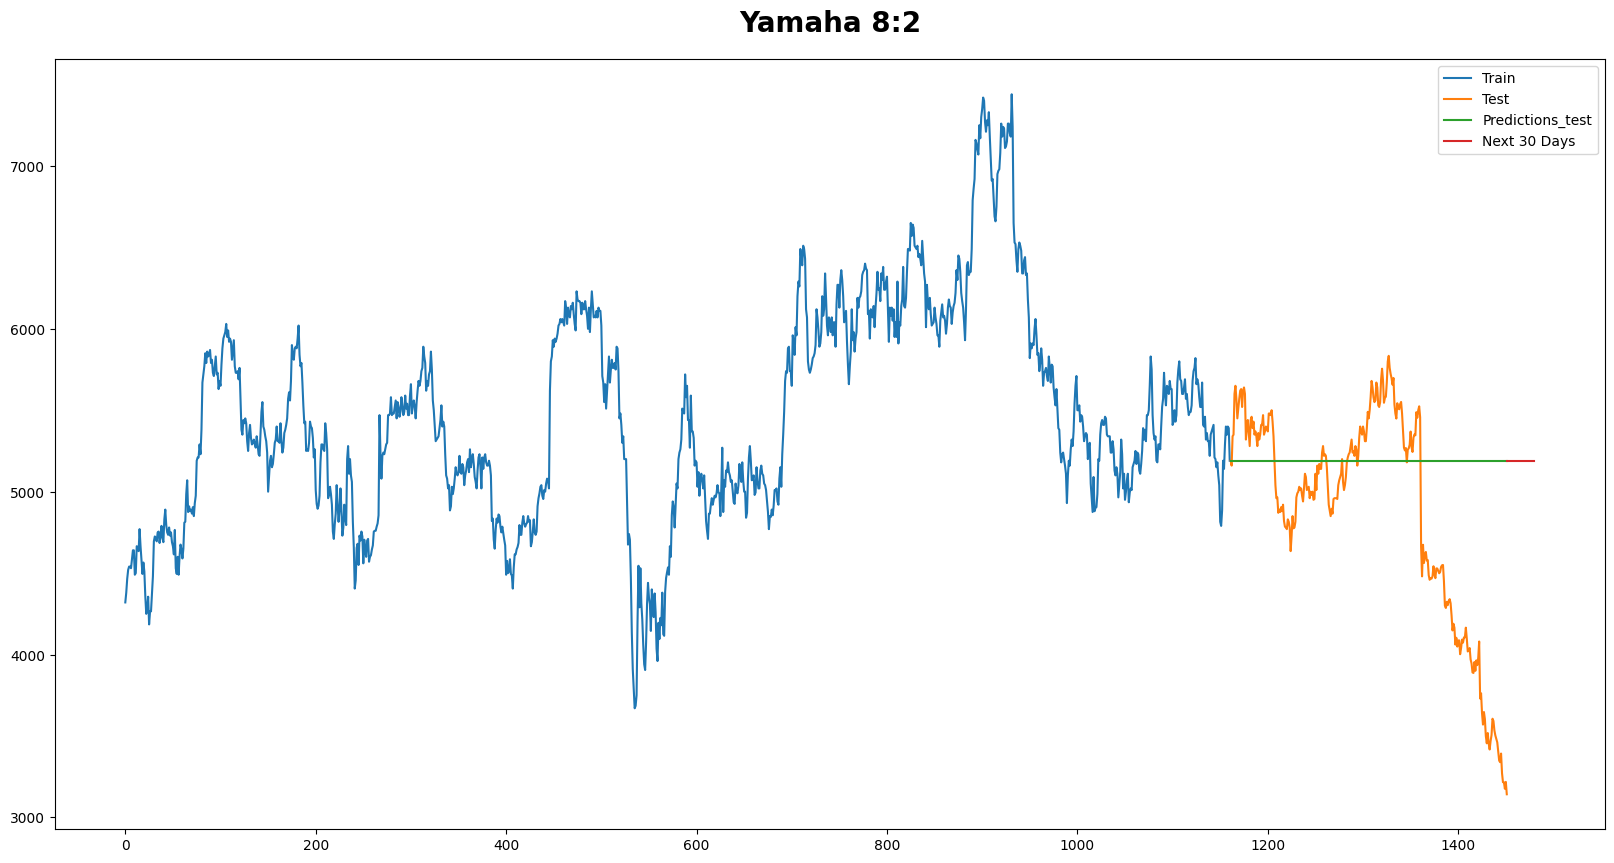

In [11]:
# Plotting the actual values and predicted values
plt.figure(figsize=(20, 10))

# Plot train data
plt.plot(train_data.index, train_data['Price'], label='Train')

# Plot test data
plt.plot(test_data.index, test_data['Price'], label='Test')

# Plot predicted values for the test set
plt.plot(test_data.index, y_pred, label='Predictions_test')

# Plot predicted values for the next 30 days
plt.plot(last_data, y_next_30_days, label='Next 30 Days')

plt.title('Yamaha 8:2', fontweight='bold', fontsize=20, pad=20)
plt.legend()
plt.show()
